<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-leo0nel09/blob/main/PLS_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100% completado
Número sugerido de componentes:  2



/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/

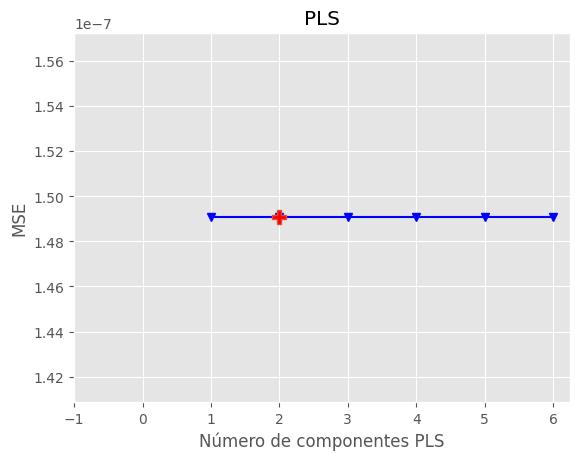

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")


R2 calibración: 1.000
MSE calibración: 0.000
MSE CV: 0.000


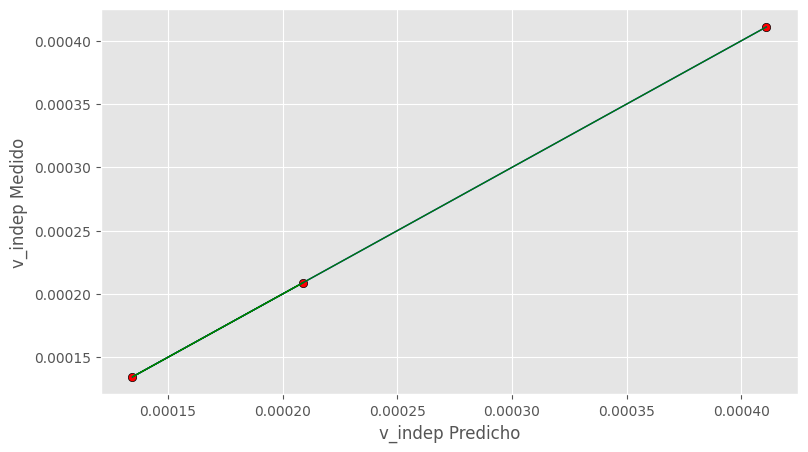

Coeficiente para imeca (pm2.5): [3.80620888e-05]
Coeficiente para imeca o3: [-3.70361823e-05]
Coeficiente para  humidex: [-2.83961256e-05]
Coeficiente para imeca so2: [2.81340897e-05]
Coeficiente para imeca (pm 10): [-2.51168919e-05]
Coeficiente para imeca no2: [-1.63591246e-05]
Coeficiente para imeca co: [-4.89735096e-06]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout

def optimizar_pls_cv(X, y, n_comp, cv=3, graficar_componentes=True):
    '''Ejecuta PLS incluyendo un número variable de componentes, hasta n_comp,
       y calcula el MSE'''
    mse = []
    componentes = np.arange(1, n_comp)

    for i in componentes:
        pls = PLSRegression(n_components=i)

        # Validación cruzada
        y_cv = cross_val_predict(pls, X, y, cv=cv)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/n_comp
        # Truco para actualizar el estado en la misma línea
        stdout.write("\r%d%% completado" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calcular e imprimir la posición del mínimo en MSE
    msemin = np.argmin(mse)
    print("Número sugerido de componentes: ", msemin+1)
    stdout.write("\n")

    if graficar_componentes is True:
        with plt.style.context(('ggplot')):
            plt.plot(componentes, np.array(mse), '-v', color='blue', mfc='blue')
            plt.plot(componentes[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Número de componentes PLS')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Definir objeto PLS con el número óptimo de componentes
    pls_opt = PLSRegression(n_components=msemin+1)

    # Ajustar al conjunto de datos completo
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Validación cruzada
    y_cv = cross_val_predict(pls_opt, X, y, cv=cv)

    # Calcular puntajes para calibración y validación cruzada
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calcular error cuadrático medio para calibración y validación cruzada
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calibración: %5.3f' % score_c)
    print('MSE calibración: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Graficar regresión y métricas
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Ajustar una línea a CV vs respuesta
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        # Graficar la línea de mejor ajuste
        ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)
        # Graficar la línea ideal 1:1
        ax.plot(y, y, color='green', linewidth=1)
        plt.xlabel('v_indep Predicho')
        plt.ylabel('v_indep Medido')

        plt.show()

    # Devolver el modelo optimizado
    return pls_opt

# Leer el archivo Excel
xl = '/content/drive/MyDrive/Variables ambientales.xlsx'
data = pd.read_excel(xl)
df = data

# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t defunciones', ' humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

# Variable dependiente y variables independientes
y = data_values[:, 0]  # 't defunciones'
X = data_values[:, 1:]  # 'humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3'

# Optimizar el modelo PLS y obtener pls_opt
pls_opt = optimizar_pls_cv(X, y, cv = 3, n_comp=7)

# Ahora puedes usar pls_opt aquí
coeficientes = pls_opt.coef_

# Obtener los índices que ordenarían los coeficientes de mayor a menor
indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))

# Imprimir los coeficientes ordenados
for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')

57% completado

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/

100% completado
Número sugerido de componentes:  2



/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/

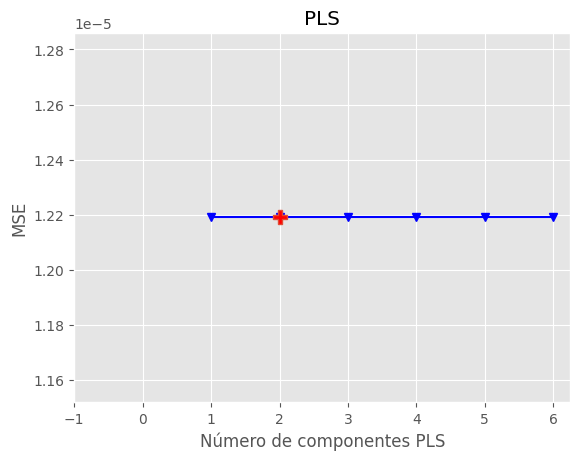

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")


R2 calibración: 1.000
MSE calibración: 0.000
MSE CV: 0.000


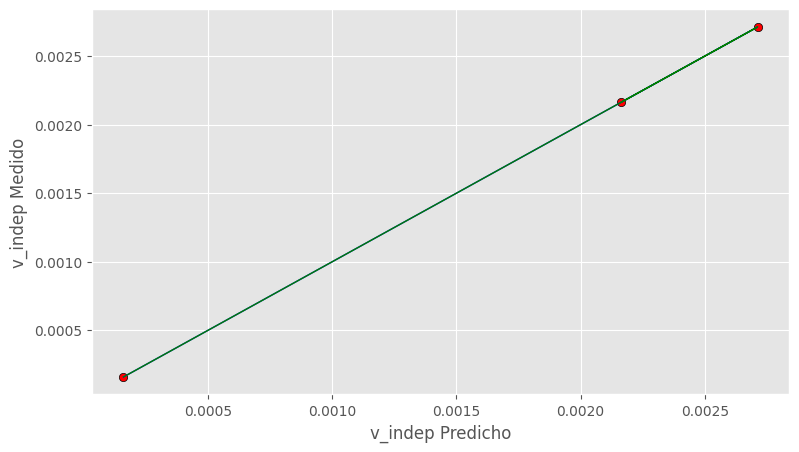

Coeficiente para imeca (pm2.5): [-0.00034678]
Coeficiente para imeca o3: [0.00033251]
Coeficiente para imeca so2: [-0.00027373]
Coeficiente para imeca (pm 10): [0.0002481]
Coeficiente para  humidex: [0.00024283]
Coeficiente para imeca no2: [0.00017186]
Coeficiente para imeca co: [6.9363882e-05]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [2]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t confirmados', ' humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

# Variable dependiente y variables independientes
y = data_values[:, 0]  # 't defunciones'
X = data_values[:, 1:]  # 'humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3'

# Optimizar el modelo PLS y obtener pls_opt
pls_opt = optimizar_pls_cv(X, y, cv = 3, n_comp=7)

# Ahora puedes usar pls_opt aquí
coeficientes = pls_opt.coef_

# Obtener los índices que ordenarían los coeficientes de mayor a menor
indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))

# Imprimir los coeficientes ordenados
for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')


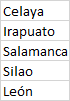

71% completado

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/

100% completado
Número sugerido de componentes:  1



/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")


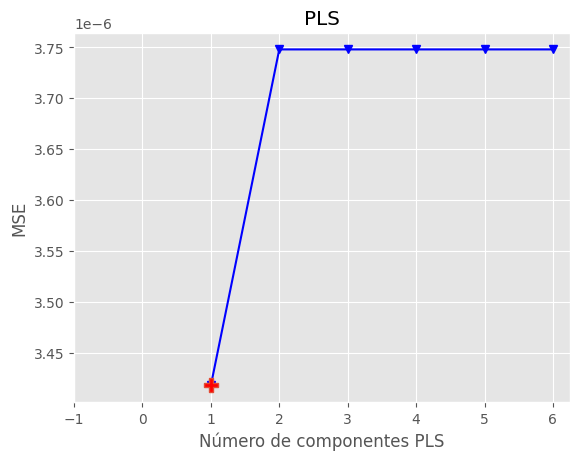

R2 calibración: 0.879
MSE calibración: 0.000
MSE CV: 0.000


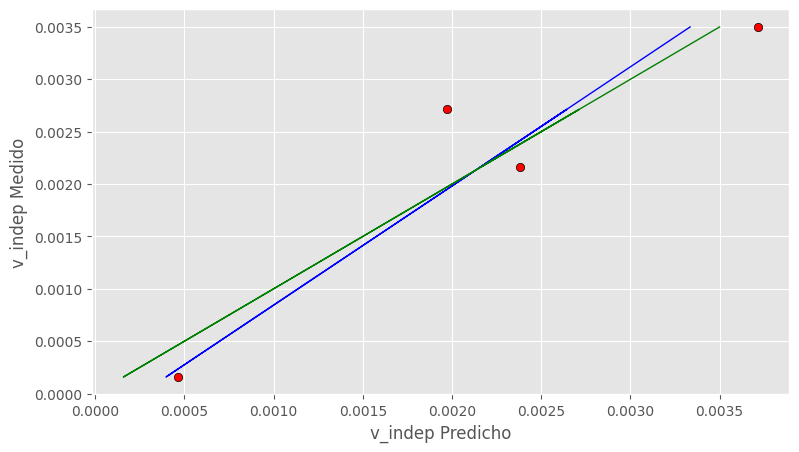

Coeficiente para imeca so2: [-0.0004628]
Coeficiente para imeca no2: [0.00044154]
Coeficiente para imeca o3: [0.00040018]
Coeficiente para imeca (pm 10): [0.00021878]
Coeficiente para imeca (pm2.5): [0.00020204]
Coeficiente para  humidex: [-0.00016914]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [3]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya', 'Silao', 'Leon']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t confirmados', ' humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca no2', 'imeca (pm 10)', 'imeca o3']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

# Variable dependiente y variables independientes
y = data_values[:, 0]  # 't defunciones'
X = data_values[:, 1:]  # 'humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3'

# Optimizar el modelo PLS y obtener pls_opt
pls_opt = optimizar_pls_cv(X, y, cv = 4, n_comp=7)

# Ahora puedes usar pls_opt aquí
coeficientes = pls_opt.coef_

# Obtener los índices que ordenarían los coeficientes de mayor a menor
indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))

# Imprimir los coeficientes ordenados
for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')

100% completado
Número sugerido de componentes:  2



/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/

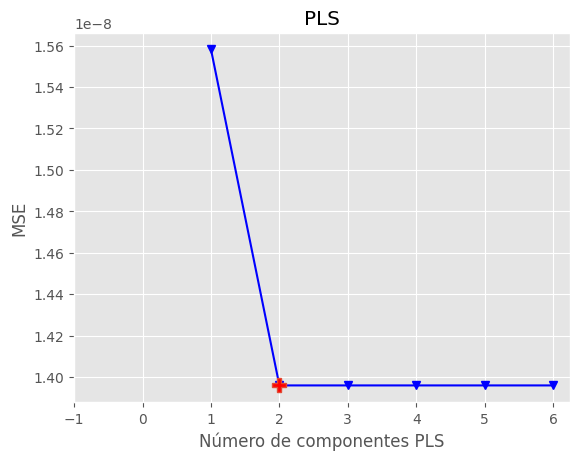

R2 calibración: 0.998
MSE calibración: 0.000
MSE CV: 0.000


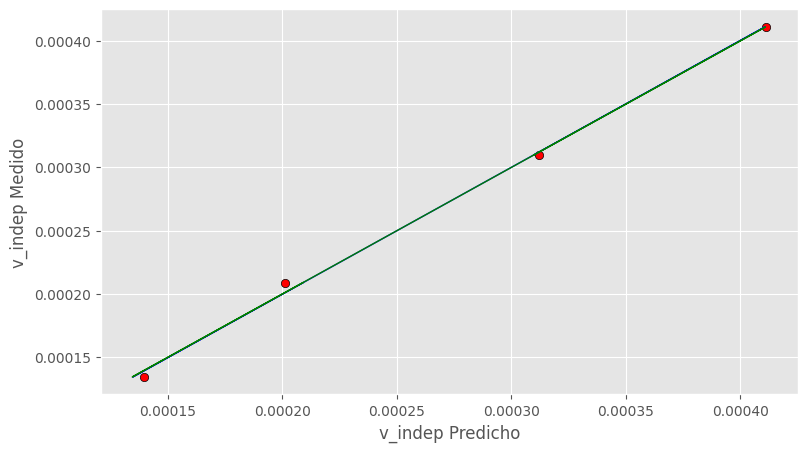

Coeficiente para imeca o3: [-5.52976472e-05]
Coeficiente para imeca (pm 10): [-4.95134247e-05]
Coeficiente para imeca (pm2.5): [2.62073349e-05]
Coeficiente para  humidex: [-2.59486933e-05]
Coeficiente para imeca no2: [-2.03039127e-05]
Coeficiente para imeca so2: [1.3041683e-05]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [13]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya', 'Silao', 'Leon']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t defunciones', ' humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca no2', 'imeca (pm 10)', 'imeca o3']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

# Variable dependiente y variables independientes
y = data_values[:, 0]  # 't defunciones'
X = data_values[:, 1:]  # 'humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3'

# Optimizar el modelo PLS y obtener pls_opt
pls_opt = optimizar_pls_cv(X, y, cv = 4, n_comp=7)

# Ahora puedes usar pls_opt aquí
coeficientes = pls_opt.coef_

# Obtener los índices que ordenarían los coeficientes de mayor a menor
indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))

# Imprimir los coeficientes ordenados
for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')

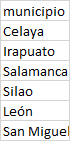

80% completado

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")


100% completado
Número sugerido de componentes:  2



/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")


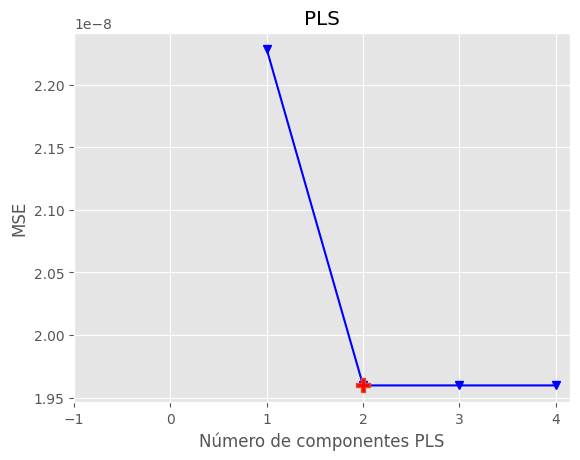

R2 calibración: 1.000
MSE calibración: 0.000
MSE CV: 0.000


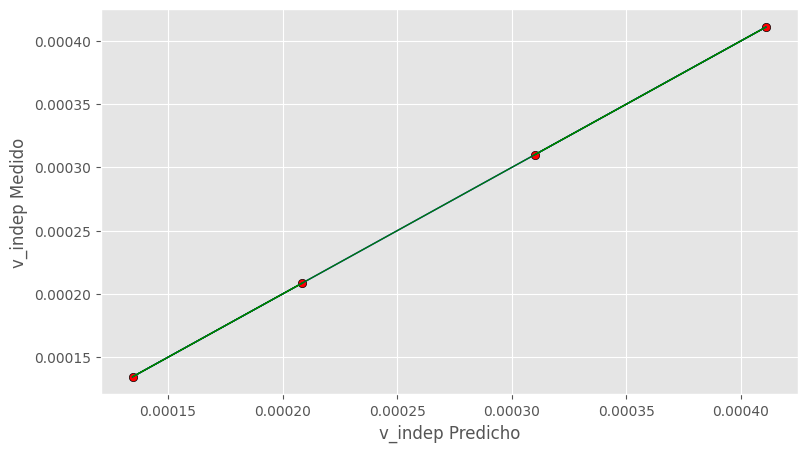

Coeficiente para imeca o3: [-7.1891969e-05]
Coeficiente para imeca (pm 10): [-6.13643762e-05]
Coeficiente para imeca (pm2.5): [9.07885204e-06]
Coeficiente para  humidex: [-8.69197143e-06]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [5]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya', 'Silao', 'Leon']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t defunciones', ' humidex', 'imeca (pm2.5)',  'imeca (pm 10)', 'imeca o3']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

# Variable dependiente y variables independientes
y = data_values[:, 0]  # 't defunciones'
X = data_values[:, 1:]  # 'humidex', 'imeca (pm2.5)', 'imeca so2' 'imeca no2', 'imeca (pm 10)', 'imeca o3'


pls_opt = optimizar_pls_cv(X, y, cv = 4, n_comp=5)


coeficientes = pls_opt.coef_


indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))

for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')

80% completado

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/

100% completado
Número sugerido de componentes:  2



/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 2
  warnings.warn(f"Y residual is constant at iteration {k}")


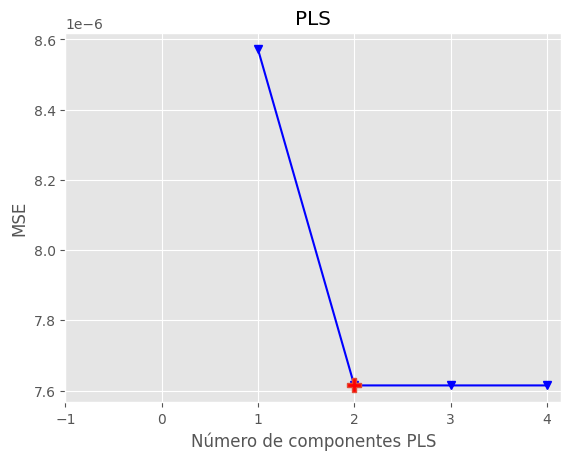

R2 calibración: 0.999
MSE calibración: 0.000
MSE CV: 0.000


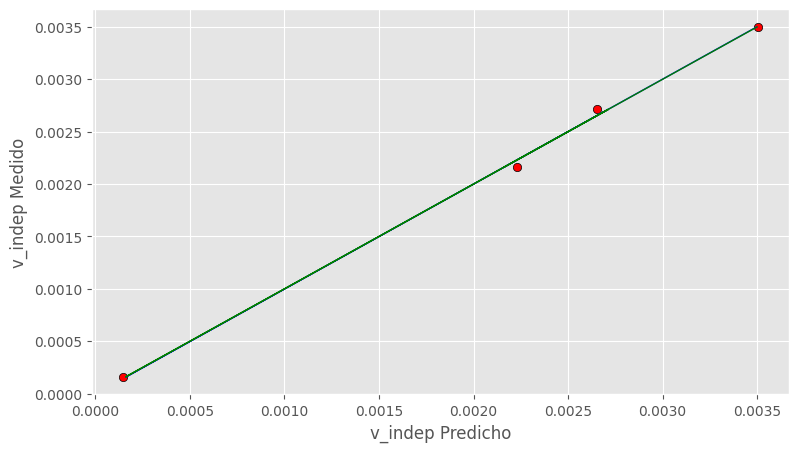

Coeficiente para imeca o3: [0.00111992]
Coeficiente para imeca (pm2.5): [0.00060784]
Coeficiente para imeca (pm 10): [0.0005675]
Coeficiente para  humidex: [-0.00050056]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [6]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya', 'Silao', 'Leon']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t confirmados', ' humidex', 'imeca (pm2.5)',  'imeca (pm 10)', 'imeca o3']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

# Variable dependiente y variables independientes
y = data_values[:, 0]  # 't defunciones'
X = data_values[:, 1:]  # 'humidex', 'imeca (pm2.5)', 'imeca so2', 'imeca co', 'imeca no2', 'imeca (pm 10)', 'imeca o3'

# Optimizar el modelo PLS y obtener pls_opt
pls_opt = optimizar_pls_cv(X, y, cv = 4, n_comp=5)

# Ahora puedes usar pls_opt aquí
coeficientes = pls_opt.coef_

# Obtener los índices que ordenarían los coeficientes de mayor a menor
indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))

# Imprimir los coeficientes ordenados
for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')

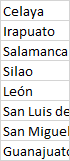

100% completado
Número sugerido de componentes:  1



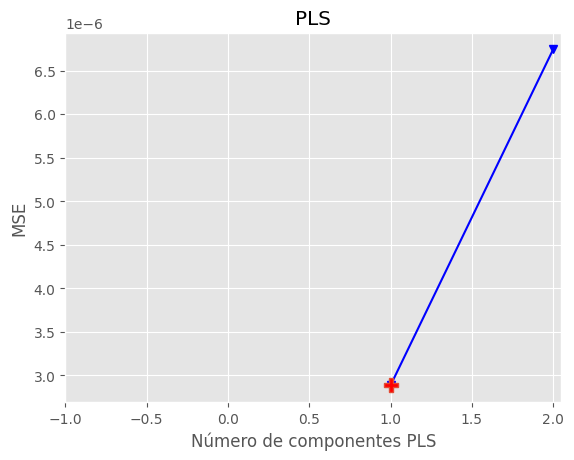

R2 calibración: 0.174
MSE calibración: 0.000
MSE CV: 0.000


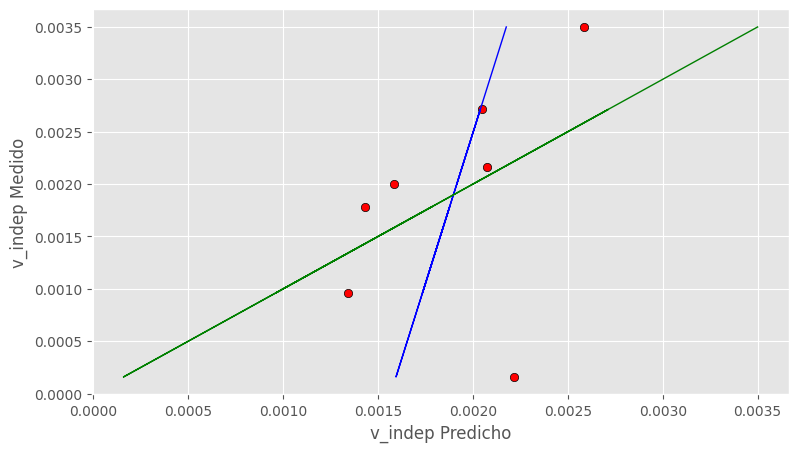

Coeficiente para imeca (pm2.5): [0.00041768]
Coeficiente para  humidex: [8.38995548e-05]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [7]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya', 'Silao', 'Leon', 'Guanajuato', 'San Miguel de Allende', 'San Luis de la Paz']
data = df[df['municipio'].isin(municipios)]

# Seleccionar columnas específicas
columnas = ['t confirmados', ' humidex', 'imeca (pm2.5)']
data = data[columnas]

# Convertir a valores de numpy después de la selección y filtrado
data_values = data.values

y = data_values[:, 0]
X = data_values[:, 1:]


pls_opt = optimizar_pls_cv(X, y, cv = 6, n_comp=3)


coeficientes = pls_opt.coef_


indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))


for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')

100% completado
Número sugerido de componentes:  1



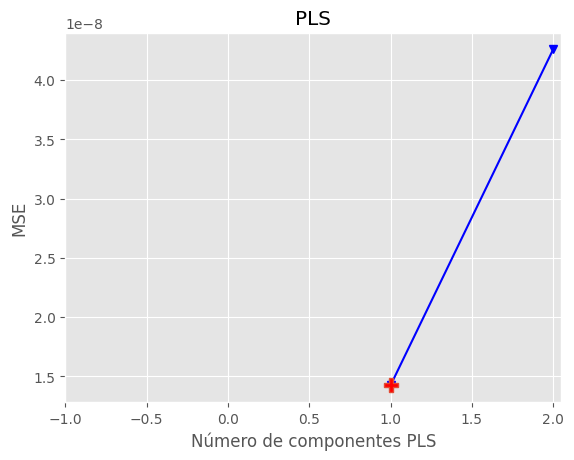

R2 calibración: 0.597
MSE calibración: 0.000
MSE CV: 0.000


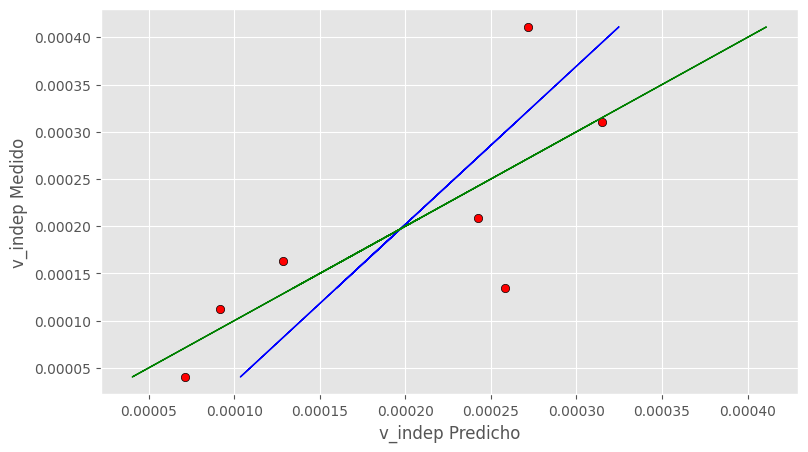

Coeficiente para imeca (pm2.5): [7.6872031e-05]
Coeficiente para  humidex: [3.65599208e-05]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [8]:
# Seleccionar municipios específicos
municipios = ['Salamanca', 'Irapuato', 'Celaya', 'Silao', 'Leon', 'Guanajuato', 'San Miguel de Allende', 'San Luis de la Paz']
data = df[df['municipio'].isin(municipios)]


columnas = ['t defunciones', ' humidex', 'imeca (pm2.5)']
data = data[columnas]

data_values = data.values


y = data_values[:, 0]
X = data_values[:, 1:]

pls_opt = optimizar_pls_cv(X, y, cv = 6, n_comp=3)


coeficientes = pls_opt.coef_


indices_ordenados = np.argsort(-np.abs(coeficientes.flatten()))


for i in indices_ordenados:
    print(f'Coeficiente para {columnas[i+1]}: {coeficientes[i]}')